In [47]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.spatial import KDTree

In [48]:
# Circularity function
def circularity(contour):
  area = cv2.contourArea(contour)
  perimeter = cv2.arcLength(contour, True)
  if(perimeter == 0):
    return 0
  return (4 * np.pi * area) / (perimeter ** 2)

In [6]:
def process_image_with_debugging(image_path):
    # Load image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    assert image is not None, "Image not found, check the path"

    # Convert image from BGR to grayscale
    gray_image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)

    # Enhance contrast using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(gray_image)

    # Apply Gaussian Blur to smooth the image
    blurred_image = cv2.GaussianBlur(enhanced_image, (5, 5), 0)

    # Apply binary thresholding for edge detection
    _, threshold_image = cv2.threshold(blurred_image, 125, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(threshold_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Total contours found: {len(contours)}")

    # Calculate perimeter, area, and circularity for each contour
    contour_data = []
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        area = cv2.contourArea(contour)
        circ = circularity(contour)
        contour_data.append((contour, perimeter, area, circ))

    # Set thresholds for contours
    max_area_threshold = 15000
    area_threshold = 1000
    min_area_threshold = 400  # Minimum area to filter out tiny circles
    min_circularity_threshold = 0.5
    max_circularity_threshold = 1.5

    # Filter contours based on circularity and area
    filtered_contours = []
    for data in contour_data:
        if ((min_area_threshold < data[2] < max_area_threshold) and
            (min_circularity_threshold <= data[3] <= max_circularity_threshold)) or \
           (min_area_threshold < data[2] < max_area_threshold):
            filtered_contours.append(data)
        else:
            print(f"Contour with area {data[2]} and circularity {data[3]} did not pass the filter.")

    print(f"Contours after filtering: {len(filtered_contours)}")

    # Draw all contours for comparison
    all_contours_image = np.array(image)
    cv2.drawContours(all_contours_image, [data[0] for data in contour_data], -1, (0, 255, 0), 2)  # All contours in green

    # Draw filtered contours on the original image
    final_contour_image = np.array(image)
    for i, data in enumerate(filtered_contours):
        cv2.drawContours(final_contour_image, [data[0]], -1, (255, 0, 255), 2)  # Filtered contours in purple

        # Calculate the centroid
        M = cv2.moments(data[0])
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            # Annotate the contour with its index
            cv2.putText(final_contour_image, f"{i}", (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            print(f"Contour {i}: Centroid at ({cx}, {cy})")
        else:
            print(f"Contour {i}: Centroid not found (area too small).")

    # Display the images with all contours and filtered contours
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))

    axs[0].imshow(cv2.cvtColor(all_contours_image, cv2.COLOR_BGR2RGB))
    axs[0].set_title('All Detected Contours')
    axs[0].axis('off')

    axs[1].imshow(cv2.cvtColor(final_contour_image, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Filtered Contours with Indices and Centroids')
    axs[1].axis('off')

    plt.show()

    return image, filtered_contours, area_threshold, final_contour_image

In [82]:
# Overview
# Loads Image, Convert to grayscale, apply binary thresholding
# Find contours, calculate perimeter area circularity
# Filter based on thresholds
def process_image(image_path):
    # Load image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    assert image is not None, "Not found, check with os.path.exists() with os module"

    # Convert image from BGR to grayscale
    gray_image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)

    # Enhance contrast using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(gray_image)

    # Apply Gaussian Blur to smooth the image
    blurred_image = cv2.GaussianBlur(enhanced_image, (5, 5), 0)

    # Apply binary thresholding for edge detection,
    _, threshold_image = cv2.threshold(blurred_image, 125, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # 128 can be changed to make it less or more sensitive
    # Makes edges white on a black background

    # Find contours
    contours, _ = cv2.findContours(threshold_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Calculate perimeter, area, and circularity for each contour
    contour_data = []
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        area = cv2.contourArea(contour)
        circ = circularity(contour)
        contour_data.append((contour, perimeter, area, circ))

    # Set thresholds for contours
    max_area_threshold = 30000
    area_threshold = 1000
    min_area_threshold = 400  # Minimum area to filter out tiny circles
    min_circularity_threshold = 0.5
    max_circularity_threshold = 1.5

    # Filter contours based on circularity and area
    filtered_contours = [data for data in contour_data if
                         ((min_area_threshold < data[2] < max_area_threshold)  and
                          (min_circularity_threshold <= data[3] <= max_circularity_threshold)) or
                          (min_area_threshold < data[2] < max_area_threshold)]

    # Draw filtered contours on the original image
    final_contour_image = np.array(image)
    for i, data in enumerate(filtered_contours):
        cv2.drawContours(final_contour_image, [data[0]], -1, (255, 0, 255), 2)  # Filtered contours in purple

        # Calculate the centroid
        M = cv2.moments(data[0])
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            # Annotate the contour with its index
            cv2.putText(final_contour_image, f"{i}", (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            print(f"Contour {i}: Centroid at ({cx}, {cy})")
        else:
            print(f"Contour {i}: Centroid not found (area too small).")

    # Display the image with filtered contours and axes
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(final_contour_image, cv2.COLOR_BGR2RGB))
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Filtered Contours with Indices and Centroids')
    plt.show()

    return image, filtered_contours, area_threshold, final_contour_image

Contour 0: Centroid at (830, 945)
Contour 1: Centroid at (313, 920)
Contour 2: Centroid at (230, 856)
Contour 3: Centroid at (553, 892)
Contour 4: Centroid at (969, 720)
Contour 5: Centroid at (676, 702)
Contour 6: Centroid at (522, 774)
Contour 7: Centroid at (323, 725)
Contour 8: Centroid at (722, 660)
Contour 9: Centroid at (1230, 623)
Contour 10: Centroid at (452, 579)
Contour 11: Centroid at (780, 566)
Contour 12: Centroid at (524, 525)
Contour 13: Centroid at (1142, 582)
Contour 14: Centroid at (655, 570)
Contour 15: Centroid at (1219, 554)
Contour 16: Centroid at (223, 550)
Contour 17: Centroid at (585, 516)
Contour 18: Centroid at (388, 482)
Contour 19: Centroid at (48, 497)
Contour 20: Centroid at (1186, 458)
Contour 21: Centroid at (423, 447)
Contour 22: Centroid at (460, 482)
Contour 23: Centroid at (542, 463)
Contour 24: Centroid at (825, 471)
Contour 25: Centroid at (1117, 430)
Contour 26: Centroid at (1261, 424)
Contour 27: Centroid at (1236, 446)
Contour 28: Centroid at 

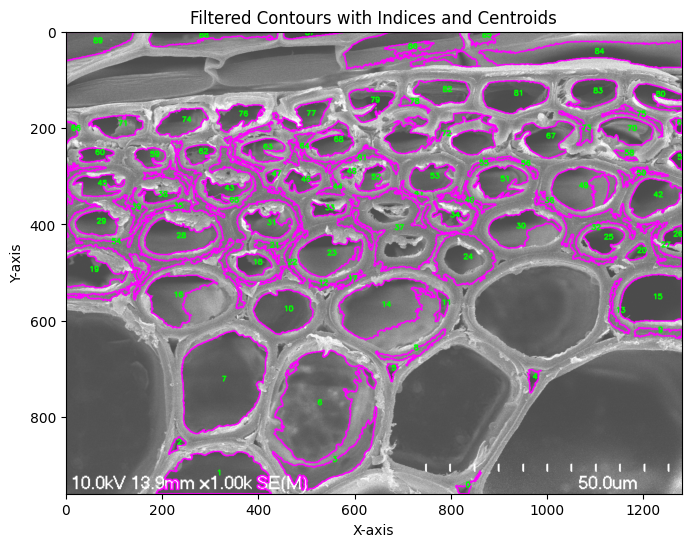

In [85]:
# Use to manually exclusion contours, cause I don't know how to make an interactive environment
image_path = ('Downloads/Cell pictures/X10-1_A_m09.tif')
image, contours, area_threshold, final_contour_image = process_image(image_path)

In [49]:
# Overview
# Loads Image, Convert to grayscale, apply binary thresholding
# Find contours, calculate perimeter area circularity
# Filter based on thresholds
def process_image_with_exclusion(image_path, exclude_coords):
    # Load image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    assert image is not None, "Not found, check with os.path.exists() with os module"

    # Convert image from BGR to grayscale
    gray_image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)

    # Enhance contrast using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(gray_image)

    # Apply Gaussian Blur to smooth the image
    blurred_image = cv2.GaussianBlur(enhanced_image, (5, 5), 0)

    # Apply binary thresholding for edge detection
    _, threshold_image = cv2.threshold(blurred_image, 125, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(threshold_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Calculate perimeter, area, and circularity for each contour
    contour_data = []
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        area = cv2.contourArea(contour)
        circ = circularity(contour)
        contour_data.append((contour, perimeter, area, circ))

    # Set thresholds for contours
    max_area_threshold = 20000
    area_threshold = 1000
    min_area_threshold = 400  # Minimum area to filter out tiny circles
    min_circularity_threshold = 0.5
    max_circularity_threshold = 1.5

    # Filter contours based on circularity and area
    filtered_contours = []
    for data in contour_data:
        if ((min_area_threshold < data[2] < max_area_threshold) and (min_circularity_threshold <= data[3] <= max_circularity_threshold)) or (min_area_threshold < data[2] < max_area_threshold):
            # Calculate the centroid
            M = cv2.moments(data[0])
            if M['m00'] != 0:
                cx = int(M['m10'] / M['m00'])
                cy = int(M['m01'] / M['m00'])
                if (cx, cy) not in exclude_coords:
                    filtered_contours.append(data)
            else:
                filtered_contours.append(data)

    # Draw filtered contours on the original image
    final_contour_image = np.array(image)
    cv2.drawContours(final_contour_image, [data[0] for data in filtered_contours], -1, (255, 0, 255), 2)  # Filtered contours in purple

    # Display the image with filtered contours
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(final_contour_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Filtered Contours based on exclusion list')
    plt.show()

    return image, filtered_contours, area_threshold, final_contour_image

In [100]:
def bounding_box_overlap(box1, box2, margin = 40):
  return not(box1[2] + margin < box2[0] or # box1 right < box2 left
             box1[0] - margin > box2[2] or # box1 left > box2 right
             box1[3] + margin < box2[1] or # box1 bottom < box2 top
             box1[1] - margin > box2[3])   # box1 top > box2 bottom

In [101]:
# Calculate centroids of contours
# Using KDTree to find neighboring contours
# Find closest points between neighboring contours
# Draw lines showing closest distances
def cwDistance(image, contours, area_threshold, max_neighbors = 8, max_distance = 100, min_distance = 5):
  distances = []
  line_coords = []
  contour_pairs = set()

  # Calculate the centroids and bounding boxes for small contours only
  centroids = []
  bounding_boxes = []
  for data in contours:
    contour = data[0]
    M = cv2.moments(contour)
    if M['m00'] != 0:
      cx = int(M['m10'] / M['m00'])
      cy = int(M['m01'] / M['m00'])
      centroids.append((cx, cy))
    else:
      centroids.append((0, 0))
    x, y, w, h = cv2.boundingRect(contour)
    bounding_boxes.append((x, y, x + w, y + h))

  print(f"Number of centroids: {len(centroids)}")

  # Create a KDTree for the centroids
  tree = KDTree(centroids)

  for i, data1 in enumerate(contours):
    contour1 = data1[0]
    points1 = contour1[:, 0, :] # extract points from contour1
    tree1 = KDTree(points1)

    # Find indices of the closest neighboring centroids
    distances_to_neighbors, neighbor_indices = tree.query(centroids[i], k=max_neighbors + 1)
    neighbor_indicies = neighbor_indices[1:] # Excludes itself

    for j in neighbor_indices:
      if i == j in contour_pairs or (j, i) in contour_pairs:
        continue
      if bounding_box_overlap(bounding_boxes[i], bounding_boxes[j]):
        contour2 = contours[j][0]
        points2 = contour2[:, 0, :] # extract points from contour2
        tree2 = KDTree(points2)

        # Find the closest point between contour1 and contour2
        min_dist = float('inf')
        closest_points = None
        for point in points1:
          dist, idx = tree2.query(point)
          if dist < min_dist:
            min_dist = dist
            closest_points = (tuple(point), tuple(points2[idx]))

        for point in points2:
          dist, idx = tree1.query(point)
          if dist < min_dist:
            min_dist = dist
            closest_points = (tuple(points1[idx]), tuple(point))

        print(f"Min distance found between contours: {min_dist}")

        # Stores and draws the closest points
        if closest_points and min_distance <= min_dist <= max_distance:
          distances.append(min_dist)
          line_coords.append(closest_points)
          cv2.line(image,closest_points[0], closest_points[1], (0, 0, 255), 2)
          contour_pairs.add((i, j))
        else:
           print(f"No valid distance found for contours {i} and {j} (min_distance={min_distance}, max_distance={max_distance})")

  # Draw contours
  cv2.drawContours(image, [data[0] for data in contours], -1, (255, 0, 0), 1) # Big contours in blue

  # Save distances as file
  with open('distances.txt', 'w') as f:
    for dist in distances:
      f.write(f'{dist}\n')

  # Display image with lines
  plt.figure(figsize = (14, 12))
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.title('Contours with Cell Wall Distances max_neighbors = 10, max_distance = 200, min_distance = 5')
  plt.show()

  return distances, line_coords

In [102]:
def remove_outliers(data):
  q1 = np.percentile(data, 25)
  q3 = np.percentile(data, 75)
  iqr = q3 - q1
  lower_bound = q1 - 1.5 * iqr
  upper_bound = q3 + 1.5 * iqr
  return [x for x in data if lower_bound <= x <= upper_bound]

In [103]:
def calculate_and_plot_statistics(image, contours):
  # Remove outliers from distances and calculate the average
  filtered_distances = remove_outliers(distances)
  average_thickness = np.mean(filtered_distances)
  print(f'Average cell wall thickness(without outliers): {average_thickness: .2f} pixels')

  # Calculate areas of big and small contours
  areas = [data[2] for data in contours]

  filtered_areas = remove_outliers(areas)
  average_area = np.mean(filtered_areas)
  print(f'Average cell area(without outliers): {average_area: .2f} pixels^2')

  # Plot box plots for distances
  plt.figure(figsize = (14, 7))

  plt.subplot(1, 2, 1)
  plt.boxplot(distances, vert = True, patch_artist = True)
  plt.title('Cell Wall thickness(include outliers)')
  plt.xlabel('Thickness (pixels)')

  plt.subplot(1, 2, 2)
  plt.boxplot(areas, vert = True, patch_artist=True)
  plt.title('Contour Areas (including outliers)')
  plt.xlabel('Area (pixels^2)')

  plt.tight_layout()
  plt.show()

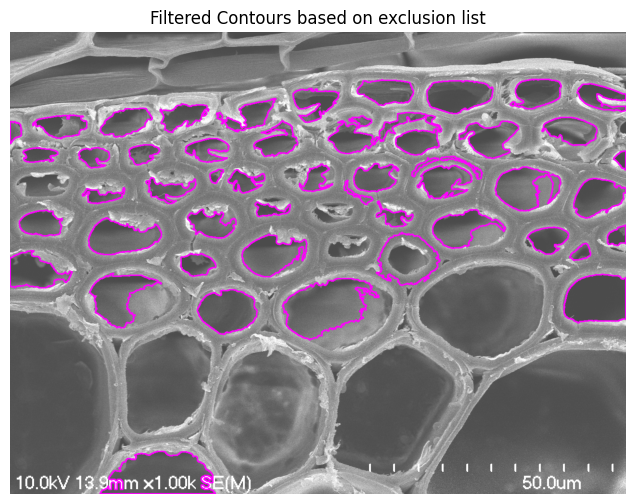

Number of centroids: 49
Min distance found between contours: 0.0
No valid distance found for contours 0 and 0 (min_distance=5, max_distance=100)
Min distance found between contours: 0.0
No valid distance found for contours 1 and 1 (min_distance=5, max_distance=100)
Min distance found between contours: 39.84971769034255
Min distance found between contours: 45.79301256742124
Min distance found between contours: 0.0
No valid distance found for contours 2 and 2 (min_distance=5, max_distance=100)
Min distance found between contours: 53.14132102234569
Min distance found between contours: 25.495097567963924
Min distance found between contours: 0.0
No valid distance found for contours 3 and 3 (min_distance=5, max_distance=100)
Min distance found between contours: 37.107950630558946
Min distance found between contours: 0.0
No valid distance found for contours 4 and 4 (min_distance=5, max_distance=100)
Min distance found between contours: 39.0
Min distance found between contours: 52.430906915673

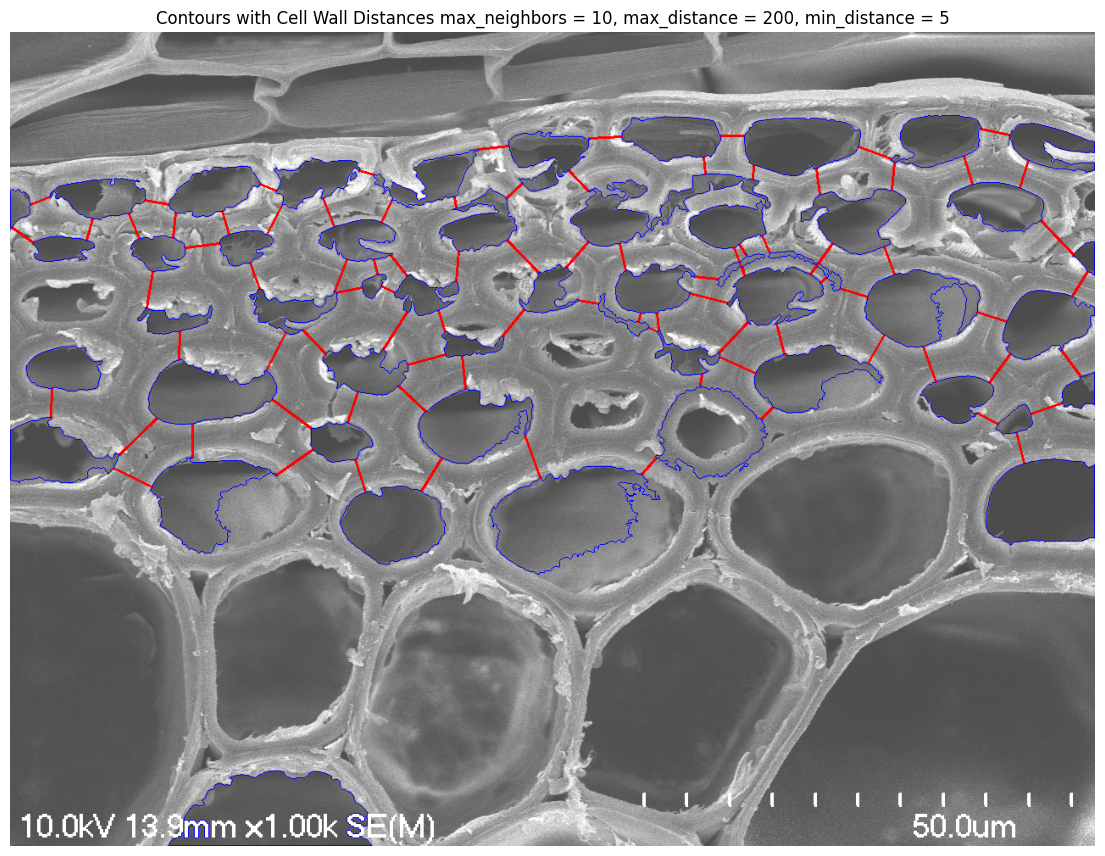

Average cell wall thickness(without outliers):  33.33 pixels
Average cell area(without outliers):  3905.86 pixels^2


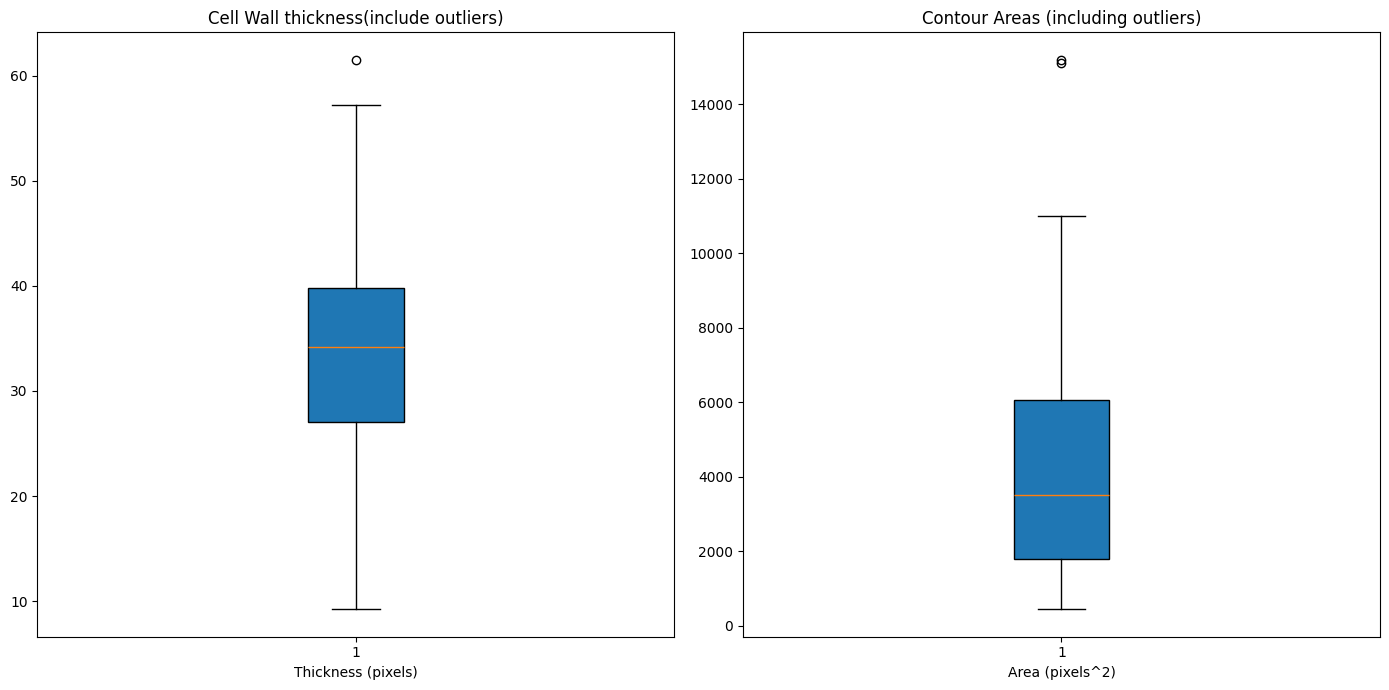

In [104]:
image_path = ('Downloads/Cell pictures/X10-1_A_m09.tif')
exclude_coords = [(830, 945), (230, 856), (553, 892), (969, 720), (676, 702), (522, 774), (1230, 623), (780, 566), (524, 525), (1142, 582), (585, 516), (423, 447), (460, 482), (1236, 446), (1091, 410), (223, 365), (994, 354), (136, 367), (828, 353), (554, 325), (65, 318), (1185, 297), (94, 439), (605, 265), (485, 241), (339, 353), (1269, 192), (1071, 203), (1185, 174), (1098, 44), (864, 10), (710, 34), (496, 5), (276, 10), (56, 22), (722, 660), (682, 410), (583, 293), (1160, 255), (714, 148)]
image, contours, area_threshold, final_contour_image = process_image_with_exclusion(image_path, exclude_coords)
distances, line_coords = cwDistance(image, contours,area_threshold, max_neighbors = 8, max_distance = 100, min_distance = 5)
calculate_and_plot_statistics(image, contours)